# Part 2

### Task A: Spatial Networks and Planarity

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Read CSV for 2017-2019
df_2017 = pd.read_csv("../data/accidents_2017.csv")
df_2018 = pd.read_csv("../data/accidents_2018.csv")
df_2019 = pd.read_csv("../data/accidents_2019.csv")

# Combined 3-year data
accidents_all = pd.concat([df_2017, df_2018, df_2019], ignore_index=True)

# Select Rename to Standard Field
accidents_all = accidents_all.rename(columns={
    'Reference Number': 'accident_id',
    'Grid Ref: Easting': 'easting',
    'Grid Ref: Northing': 'northing'
})[['accident_id', 'easting', 'northing']]

# Remove missing values
accidents_all.dropna(inplace=True)

print(f"Total {len(accidents_all)} accident records after cleaning")
accidents_all.head()

Total 4110 accident records after cleaning


,accident_id,easting,northing
0,3AP0313,426340,428455
1,3BE0850,430828,433222
2,4110858,428940,429856
3,4110858,428940,429856
4,4111495,429899,434277


In [9]:
import folium
from folium.plugins import HeatMap

# Create the center of the map (Leeds center point)
m = folium.Map(location=[53.8008, -1.5491], zoom_start=12, tiles="cartodb positron")

# Create a list of accident coordinates (convert to latitude and longitude using easting/northing)
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:27700", "epsg:4326")
accidents_all['lat'], accidents_all['lon'] = transformer.transform(
    accidents_all['northing'].values, accidents_all['easting'].values
)

# Filter out invalid conversion results
accidents_all.dropna(subset=['lat', 'lon'], inplace=True)

# Construct a list of coordinate points
accident_coords = accidents_all[['lat', 'lon']].values.tolist()

# Add a thermal layer
HeatMap(accident_coords, radius=6, blur=10).add_to(m)

m

In [10]:
import osmnx as ox

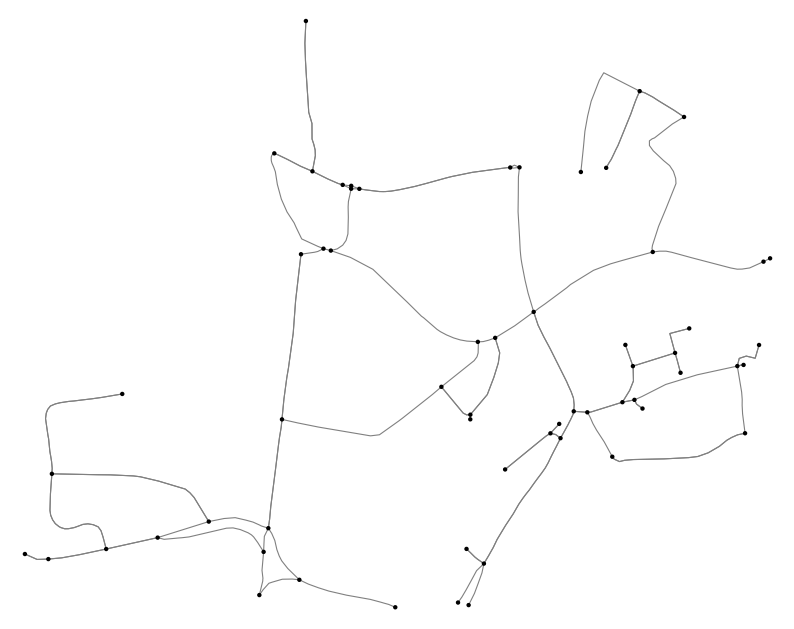

In [11]:
# Center point coordinates (Leeds center)
center_point = (53.7958, -1.5455)

# Using the graph submodule
G_leeds = ox.graph.graph_from_point(
    center_point,
    dist=500,               # The radius is 500 meters, covering about 1 square kilometer
    dist_type='bbox',       # Use rectangular bounds
    network_type='drive'    # Drivable roads only
)

# Visualizing the network
fig, ax = ox.plot_graph(
    G_leeds,
    bgcolor='white',               # White background
    node_color='black',            # Nodes are black dots
    node_size=10,
    edge_color='gray',             # Light gray edges
    edge_linewidth=0.8,
    show=True,
    close=True,
    figsize=(10, 10)
)

In [12]:
import networkx as nx

# Projected graph
G_proj = ox.project_graph(G_leeds)

# Convert to an undirected graph and obtain the maximum connected subgraph
G_undirected = G_proj.to_undirected()
largest_cc = max(nx.connected_components(G_undirected), key=len)
subgraph = G_undirected.subgraph(largest_cc)

# Use edge length (in meters) to calculate the "space diameter"
lengths = dict(nx.all_pairs_dijkstra_path_length(subgraph, weight='length'))
spatial_diameter_m = max(max(d.values()) for d in lengths.values())

print(f"Spatial Diameter (weighted by length): {spatial_diameter_m:.2f} meters")

Spatial Diameter (weighted by length): 1536.60 meters


The weighted spatial diameter of the actual street length can more accurately reflect the maximum driving distance of the road network, so the unweighted topological diameter is not selected.

In [13]:
# Convert edges and nodes to GeoDataFrame
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)

# Average street length
edge_lengths = edges_proj['length']
avg_street_length = edge_lengths.mean()
print(f"Average Street Length: {avg_street_length:.2f} meters")

Average Street Length: 77.13 meters


In [14]:
# Area
area_km2 = nodes_proj.unary_union.convex_hull.area / 1e6

# Node density, edge density
num_nodes = len(G_proj.nodes)
num_edges = len(G_proj.edges)
node_density = num_nodes / area_km2
edge_density = num_edges / area_km2

# Intersection density (degree ≥ 3)
intersections = [n for n, d in G_proj.degree() if d >= 3]
intersection_density = len(intersections) / area_km2

print(f"Area: {area_km2:.4f} km²")
print(f"Node Density: {node_density:.2f} per km²")
print(f"Edge Density: {edge_density:.2f} per km²")
print(f"Intersection Density: {intersection_density:.2f} per km²")

Area: 0.4226 km²
Node Density: 144.34 per km²
Edge Density: 253.20 per km²
Intersection Density: 94.65 per km²


/var/folders/dl/kdk6kjfj2p5fbtpmhk4629440000gn/T/ipykernel_47305/2511338474.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_km2 = nodes_proj.unary_union.convex_hull.area / 1e6


In [15]:
# Calculate the total length of the actual road network
actual_total_length = sum(nx.get_edge_attributes(subgraph, 'length').values())

# Calculate the length of the minimum spanning tree
mst = nx.minimum_spanning_tree(subgraph, weight='length')
mst_total_length = sum(nx.get_edge_attributes(mst, 'length').values())

# Average Circuitry
avg_circuitry_mst = actual_total_length / mst_total_length
print(f"Average Circuitry (using MST): {avg_circuitry_mst:.4f}")

Average Circuitry (using MST): 1.3030


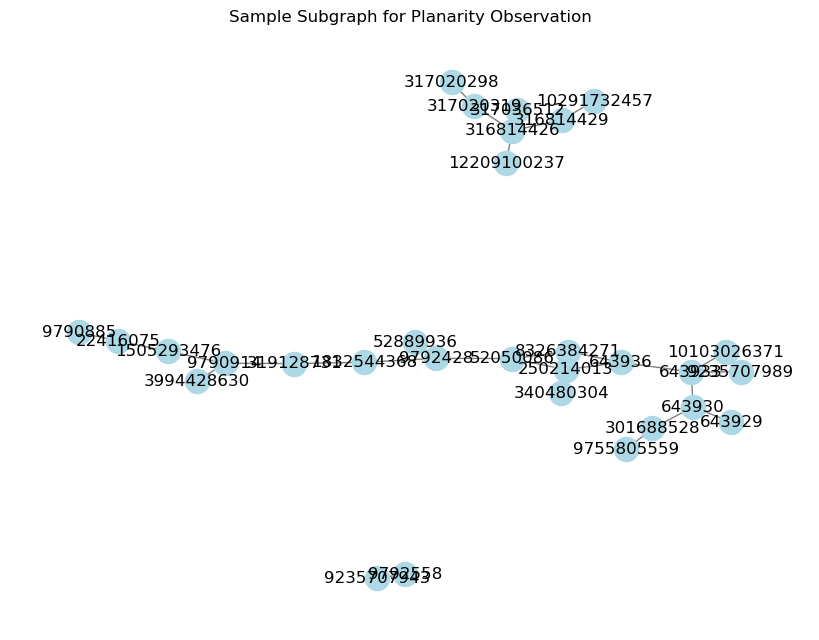

In [16]:
# Select a small subgraph (the first N nodes) from the largest connected subgraph to visualize whether there are edge crossings
sample_nodes = list(subgraph.nodes())[:30]
sample_subgraph = subgraph.subgraph(sample_nodes)

# Draw to see if there are any edge overlaps or intersections
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(sample_subgraph, seed=42)
nx.draw(sample_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Sample Subgraph for Planarity Observation")
plt.show()

In [17]:
# Determine whether it is a planar graph
is_planar, _ = nx.check_planarity(subgraph)
print("Is the network planar?", is_planar)

Is the network planar? True


In [18]:
print(f"Number of nodes: {subgraph.number_of_nodes()}")
print(f"Number of edges: {subgraph.number_of_edges()}")

Number of nodes: 61
Number of edges: 70


### Task B: Road Accidents

In [19]:
import geopandas as gpd
from shapely.geometry import Point

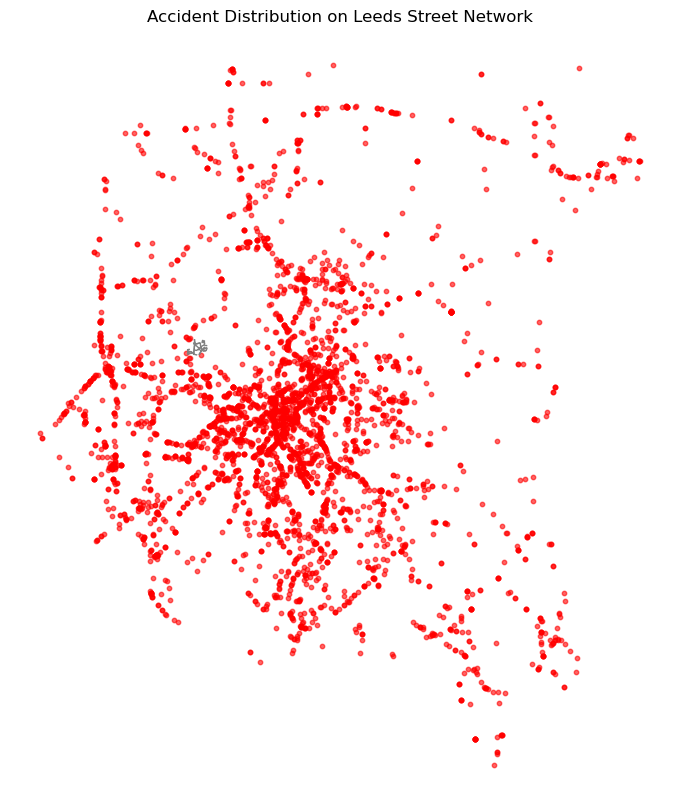

In [20]:
# Convert the accident data to a GeoDataFrame
accident_points = [Point(xy) for xy in zip(accidents_all['lon'], accidents_all['lat'])]
gdf_accidents = gpd.GeoDataFrame(geometry=accident_points, crs='EPSG:4326')
gdf_accidents = gdf_accidents.to_crs(G_proj.graph['crs'])  # 投影匹配

# Visualization overlaid on road network
fig, ax = plt.subplots(figsize=(10, 10))
edges_proj.plot(ax=ax, linewidth=1, color='gray')
gdf_accidents.plot(ax=ax, markersize=10, color='red', alpha=0.6)
plt.title("Accident Distribution on Leeds Street Network")
plt.axis("off")
plt.show()

In [75]:
import numpy as np
from shapely.geometry import LineString
from scipy.spatial import cKDTree
from libpysal.weights import KNN
from esda.moran import Moran
from collections import Counter
import spaghetti as spgh

In [76]:
# Unified coordinate system
if gdf_accidents.crs != edges_proj.crs:
    gdf_accidents = gdf_accidents.to_crs(edges_proj.crs)

# Construct the Spaghetti Network
ntw = spgh.Network(in_data=edges_proj)

In [77]:
# Construct edge midpoint KDTree
edge_centers = edges_proj.geometry.interpolate(0.5, normalized=True)
edge_coords = np.array([(pt.x, pt.y) for pt in edge_centers])
tree = cKDTree(edge_coords)

# Query the nearest edge of each accident point
acc_coords = np.array([(pt.x, pt.y) for pt in gdf_accidents.geometry])
distances, idx = tree.query(acc_coords, distance_upper_bound=200)
matched_mask = distances != np.inf

In [78]:
# Count the number of occurrences of the matched arc_id
arc_ids = idx[matched_mask]
arc_counter = Counter(arc_ids)

# Build GeoDataFrame of edges and number of accidents
edge_records = []
for i, arc in enumerate(ntw.arcs):
    coords = [ntw.vertex_coords[v] for v in arc]
    edge_records.append({
        "edge_id": i,
        "geometry": LineString(coords),
        "acc_count": arc_counter.get(i, 0)
    })

accident_counts = gpd.GeoDataFrame(edge_records, crs=edges_proj.crs)

In [79]:
# Constructing the spatial weight matrix (KNN)
w = KNN.from_dataframe(accident_counts, k=4)

# Calculate Moran's I
values = accident_counts["acc_count"].reindex(w.id_order).fillna(0).values
moran = Moran(values, w)

# Output
print("Snap completed & weight building completed")
print(accident_counts["acc_count"].describe())
print(f"Moran’s I: {moran.I:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

/opt/miniconda3/envs/nda/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Snap completed & weight building completed
count    141261.000000
mean          0.015907
std           0.250120
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: acc_count, dtype: float64
Moran’s I: 0.0627
p-value: 0.0010


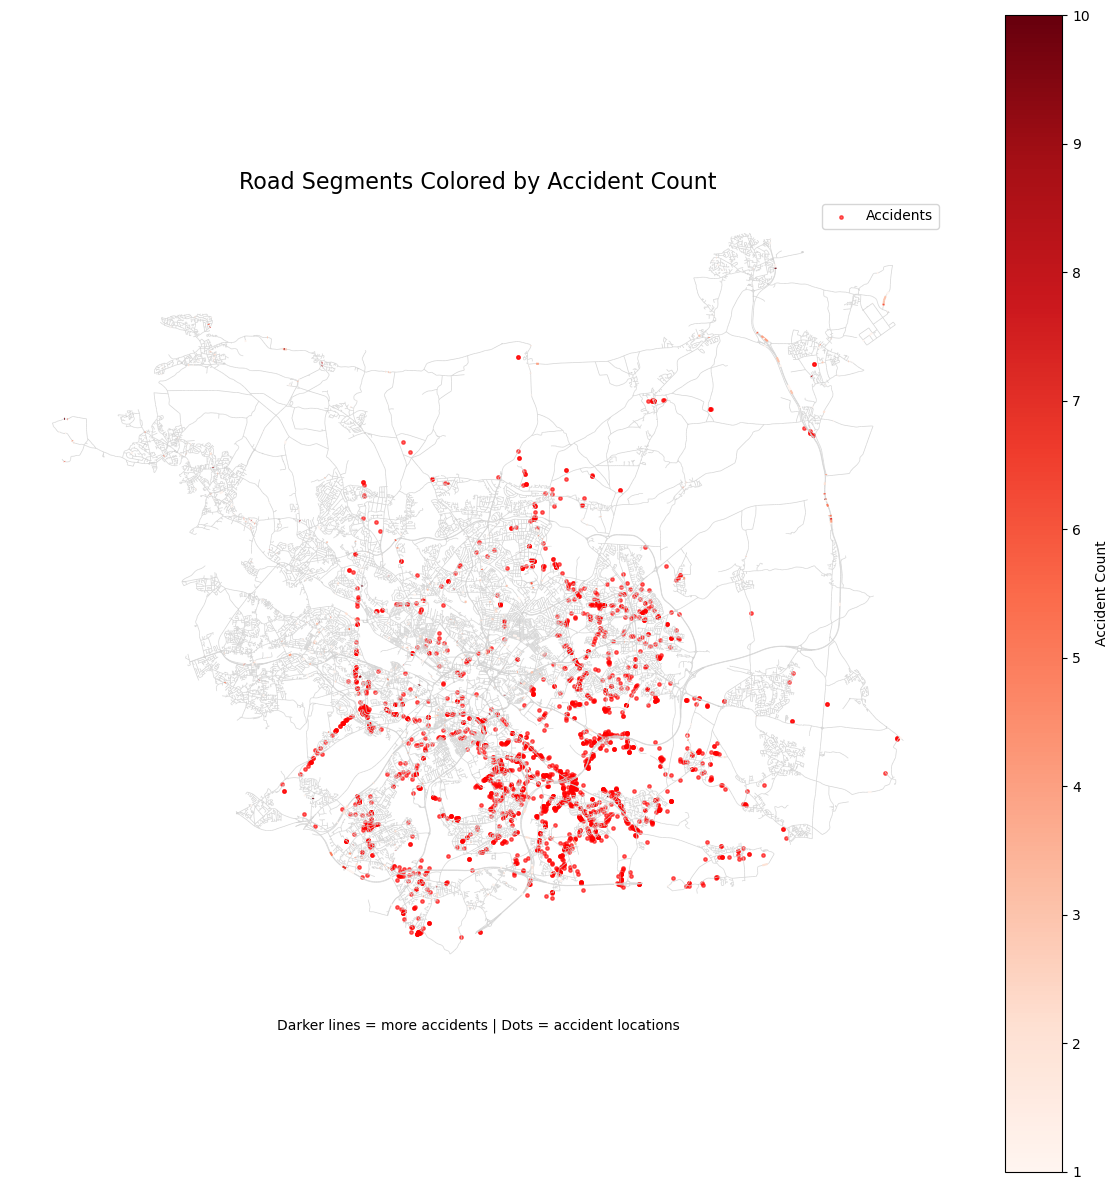

In [88]:
# First pick out the hot spots (acc_count > 0)
hot_edges = accident_counts[accident_counts["acc_count"] > 0]

fig, ax = plt.subplots(figsize=(12, 12))

# Background image: all edges (gray)
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.5)

# Hot spot layer: acc_count shading
hot_edges.plot(
    ax=ax,
    column="acc_count",
    cmap="Reds",
    linewidth=1.5,
    legend=True,
    legend_kwds={"label": "Accident Count"},
    vmin=1,
    vmax=10
)

# Superposition of accident points
gdf_accidents_matched.plot(
    ax=ax,
    color="red",
    markersize=6,
    alpha=0.6,
    label="Accidents"
)

# Title + Description
plt.title("Road Segments Colored by Accident Count", fontsize=16)
ax.annotate("Darker lines = more accidents | Dots = accident locations",
            xy=(0.5, -0.05), xycoords="axes fraction", ha="center", fontsize=10)

plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

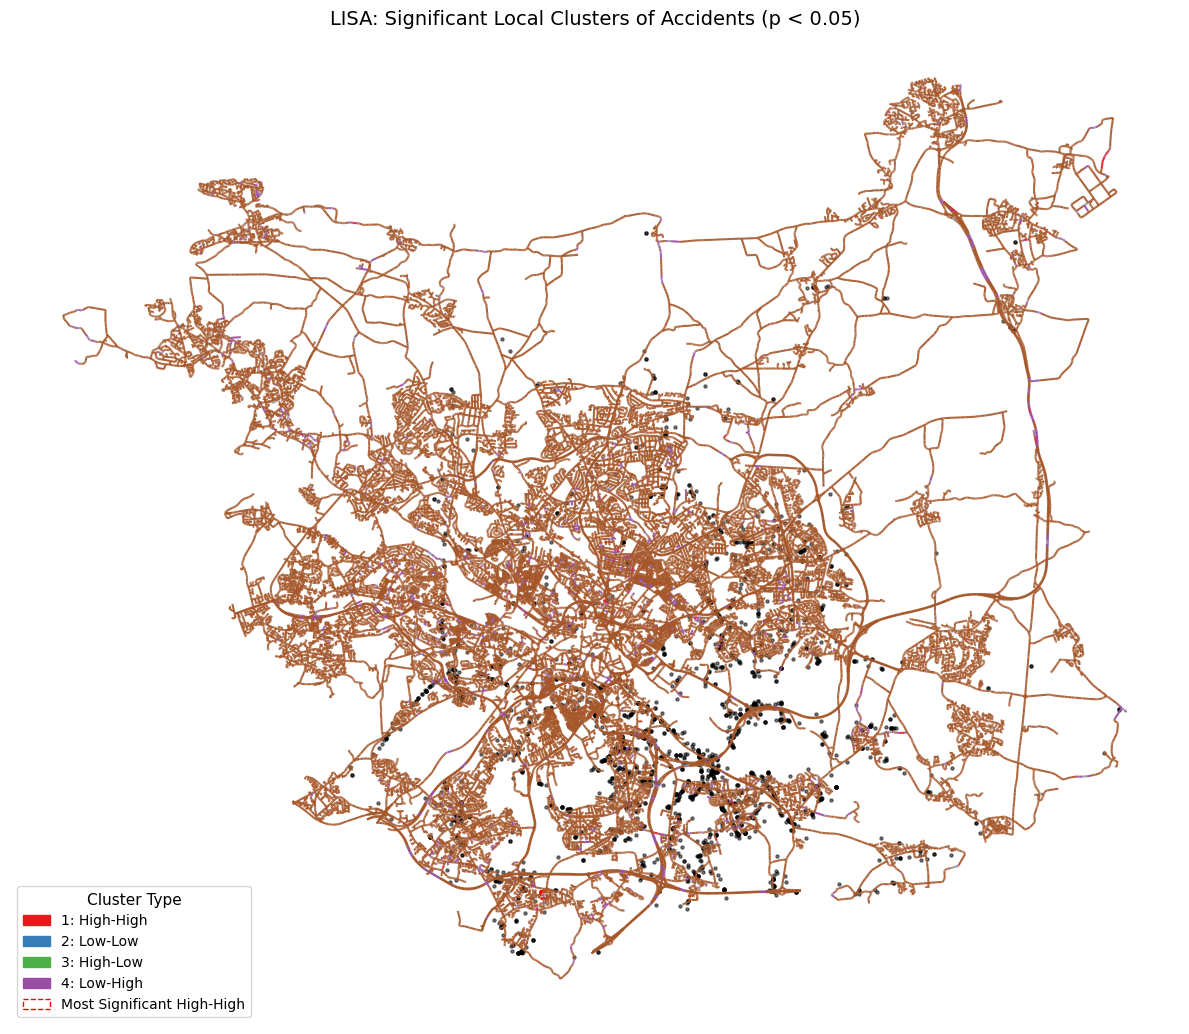

In [114]:
from esda.moran import Moran_Local
import matplotlib.patches as mpatches

# LISA calculations
lisa = Moran_Local(values, w)
accident_counts["Is"] = lisa.Is
accident_counts["p_sim"] = lisa.p_sim
accident_counts["significant"] = lisa.p_sim < 0.05
accident_counts["quadrant"] = lisa.q

# Get the significant High-High area
high_high = accident_counts[
    (accident_counts["significant"]) & (accident_counts["quadrant"] == 1)
]

# Get the High-High edge with the most accidents
top_edge = high_high.sort_values("acc_count", ascending=False).iloc[0:1]
top_bbox = top_edge.geometry.buffer(100).envelope  # Construct bbox (100m buffer)

fig, ax = plt.subplots(figsize=(12, 12))

# Road Background
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.3)

# Significantly clustered edges (using Set1 to distinguish four types)
accident_counts[accident_counts["significant"]].plot(
    ax=ax,
    column="quadrant",
    categorical=True,
    cmap="Set1",
    linewidth=1.5,
    legend=False,
    alpha=0.9
)

# Highlight bbox area
top_bbox.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, linestyle="--", label="Most Significant High-High")

# Superposition of accident points
gdf_accidents_matched.plot(
    ax=ax,
    color="black",
    markersize=5,
    alpha=0.5,
    label="Accidents"
)

# legend
legend_labels = {
    1: "High-High",
    2: "Low-Low",
    3: "High-Low",
    4: "Low-High"
}
handles = [
    mpatches.Patch(color=plt.cm.Set1(i - 1), label=f"{i}: {legend_labels[i]}")
    for i in range(1, 5)
]
handles.append(
    mpatches.Patch(edgecolor="red", facecolor="none", linestyle="--", label="Most Significant High-High")
)

plt.legend(handles=handles, loc="lower left", title="Cluster Type", fontsize=10, title_fontsize=11)

# Title & Layout
plt.title("LISA: Significant Local Clusters of Accidents (p < 0.05)", fontsize=14)
plt.axis("off")
plt.tight_layout()

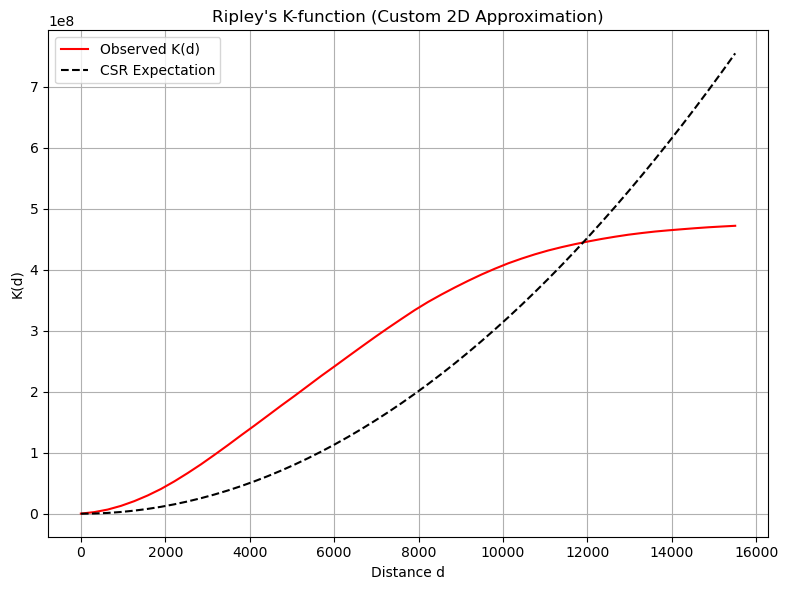

In [140]:
from scipy.spatial import KDTree

# Get the coordinates of snapped points ((x, y) tuples)
coords = [tuple(val["coordinates"]) for val in pp.points.values()]
coords = np.array(coords)

# Building a KDTree
tree = KDTree(coords)

# Setting parameters
n_points = len(coords)
area = np.ptp(coords[:, 0]) * np.ptp(coords[:, 1]) 
max_dist = np.linalg.norm([np.ptp(coords[:, 0]), np.ptp(coords[:, 1])]) / 2
radii = np.linspace(0, max_dist, 50)

# Calculate K-function
k_values = []
for r in radii:
    counts = tree.query_ball_point(coords, r, return_length=True) - 1  # exclude self
    k_r = area / (n_points ** 2) * counts.sum()
    k_values.append(k_r)

# Visualization
plt.figure(figsize=(8, 6))
plt.plot(radii, k_values, label="Observed K(d)", color="red")
plt.plot(radii, np.pi * radii**2, 'k--', label="CSR Expectation")
plt.xlabel("Distance d")
plt.ylabel("K(d)")
plt.title("Ripley's K-function (Custom 2D Approximation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

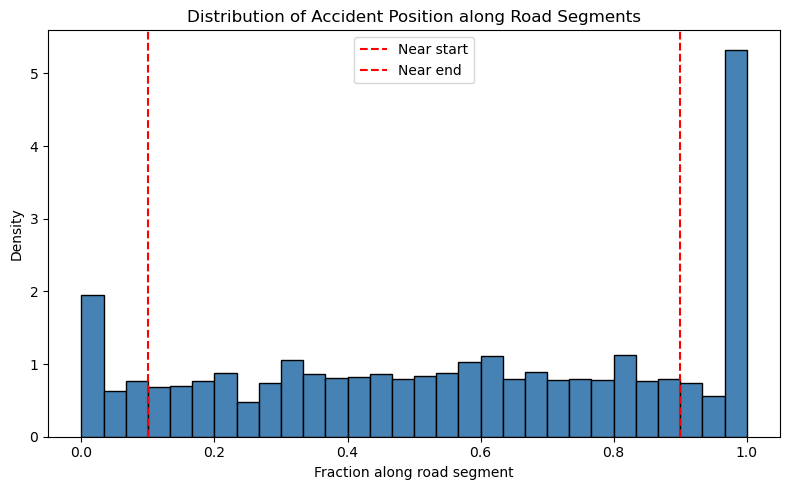

In [147]:
fraction_along = []

for arc_key, arc_info in pp.obs_to_arc.items():
    if isinstance(arc_info, dict):
        for obs_id_str, snapped_xy in arc_info.items():
            pt_data = pp.points.get(obs_id_str)
            if pt_data is None:
                continue

            coords = pt_data.get("coordinates")
            if coords is None:
                continue

            snapped_pt = Point(coords)

            # Check arc_id
            arc_id = None
            for i, arc in enumerate(ntw.arcs):
                if tuple(arc) == arc_key or tuple(arc[::-1]) == arc_key:
                    arc_id = i
                    break
            if arc_id is None:
                continue

            # Constructing line segments
            try:
                arc = ntw.arcs[arc_id]
                p1 = Point(ntw.vertex_coords[arc[0]])
                p2 = Point(ntw.vertex_coords[arc[1]])
                line = LineString([p1, p2])
            except:
                continue

            # Calculate the normalized position
            if line.length > 0:
                frac = line.project(snapped_pt) / line.length
                fraction_along.append(frac)

# Visualizations
plt.figure(figsize=(8, 5))
plt.hist(fraction_along, bins=30, color="steelblue", edgecolor="black", density=True)
plt.axvline(0.1, color='red', linestyle='--', label="Near start")
plt.axvline(0.9, color='red', linestyle='--', label="Near end")
plt.xlabel("Fraction along road segment")
plt.ylabel("Density")
plt.title("Distribution of Accident Position along Road Segments")
plt.legend()
plt.tight_layout()
plt.show()

In [149]:
# Calculate the proportion of intersections
near_intersection = sum((x < 0.1 or x > 0.9) for x in fraction_along)
print(f"{near_intersection} / {len(fraction_along)} accidents (~{near_intersection / len(fraction_along):.2%}) happen near intersections.")

746 / 2247 accidents (~33.20%) happen near intersections.


### Task C: Voronoi Diagrams

In [167]:
from libpysal.cg.voronoi import voronoi
from shapely.ops import nearest_points
from sklearn.cluster import MiniBatchKMeans

/var/folders/dl/kdk6kjfj2p5fbtpmhk4629440000gn/T/ipykernel_47305/2774652606.py:33: FutureWarning: The 'voronoi' function is considered private and will be removed in a future release.
  vor_data = _voronoi([ (pt.x, pt.y) for pt in seed_points ], radius=1e6)
/opt/miniconda3/envs/nda/lib/python3.11/site-packages/libpysal/cg/voronoi.py:70: FutureWarning: The 'voronoi_regions' function is considered private and will be removed in a future release.
  vor = voronoi_regions(Voronoi(points), radius=radius)
/var/folders/dl/kdk6kjfj2p5fbtpmhk4629440000gn/T/ipykernel_47305/2774652606.py:53: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  voronoi_polygons.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)


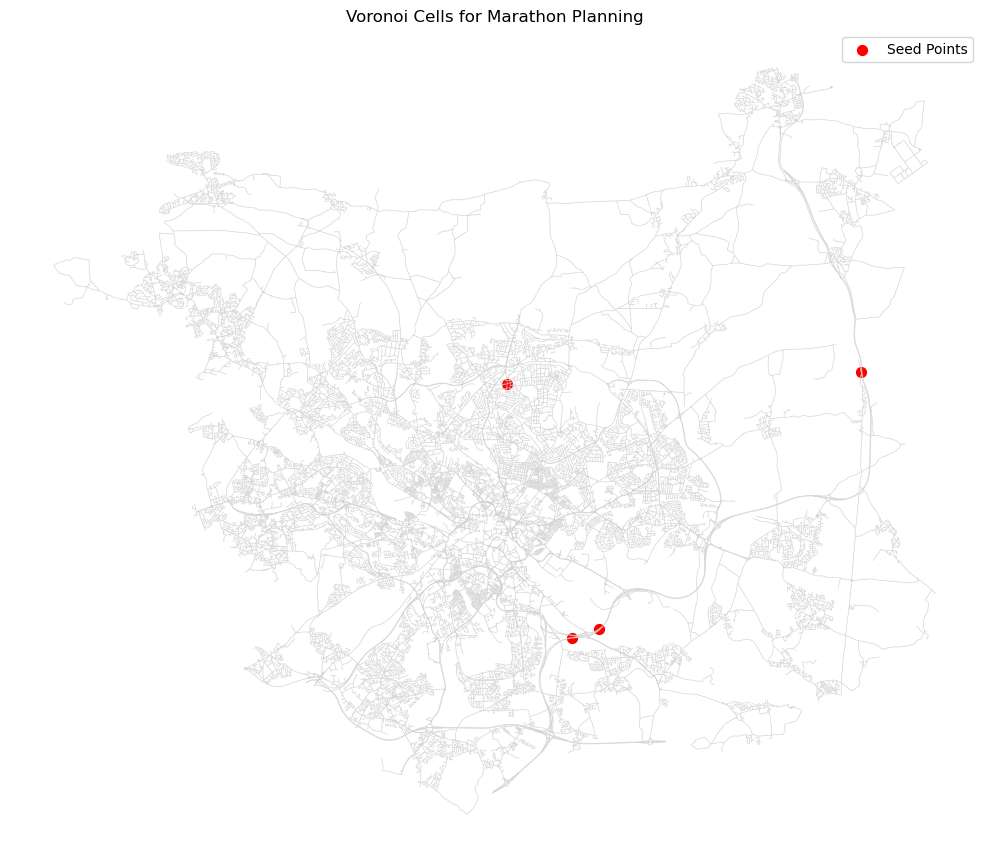

In [168]:
# Select 4 seed points using KMeans clustering (clustering on all edge midpoints)
edge_centers = accident_counts.geometry.interpolate(0.5, normalized=True)
coords = np.array([[pt.x, pt.y] for pt in edge_centers])

mbk = MiniBatchKMeans(n_clusters=4, init_size=500, batch_size=128, random_state=42)
mbk.fit(coords)
cluster_centers = mbk.cluster_centers_

# Select the safest (least accident) edge center in each cluster as a seed
seed_points = []
for label in range(4):
    indices_in_cluster = np.where(mbk.labels_ == label)[0]
    best_idx = None
    min_acc = float("inf")
    
    for idx in indices_in_cluster:
        acc = accident_counts.iloc[idx]["acc_count"]
        if acc < min_acc:
            min_acc = acc
            best_idx = idx
    
    pt = edge_centers.iloc[best_idx]
    seed_points.append(Point(pt.x, pt.y))

# Constructing a GeoDataFrame of seed points
seed_gdf = gpd.GeoDataFrame(geometry=seed_points, crs=accident_counts.crs)

# Use libpysal's voronoi to build a network Voronoi diagram
from shapely.geometry import Polygon
from libpysal.cg.voronoi import voronoi as _voronoi

# Generate Voronoi data (get region vertex indices)
vor_data = _voronoi([ (pt.x, pt.y) for pt in seed_points ], radius=1e6)

# Get the point coordinates used to construct the polygon (matching the index)
coords_array = np.array([ (pt.x, pt.y) for pt in seed_points ])
regions = []

for region in vor_data:
    try:
        poly_coords = [vor_data.vertices[i] for i in region]
        poly = Polygon(poly_coords)
        regions.append(poly)
    except:
        continue  # Skip possible exceptions

# Construct GeoDataFrame
voronoi_polygons = gpd.GeoDataFrame(geometry=regions, crs=accident_counts.crs)

# Visualizing Voronoi Partitions + Seed Points
fig, ax = plt.subplots(figsize=(10, 10))
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.5)
voronoi_polygons.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
seed_gdf.plot(ax=ax, color="red", markersize=50, label="Seed Points")

plt.title("Voronoi Cells for Marathon Planning")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

In [169]:
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, box

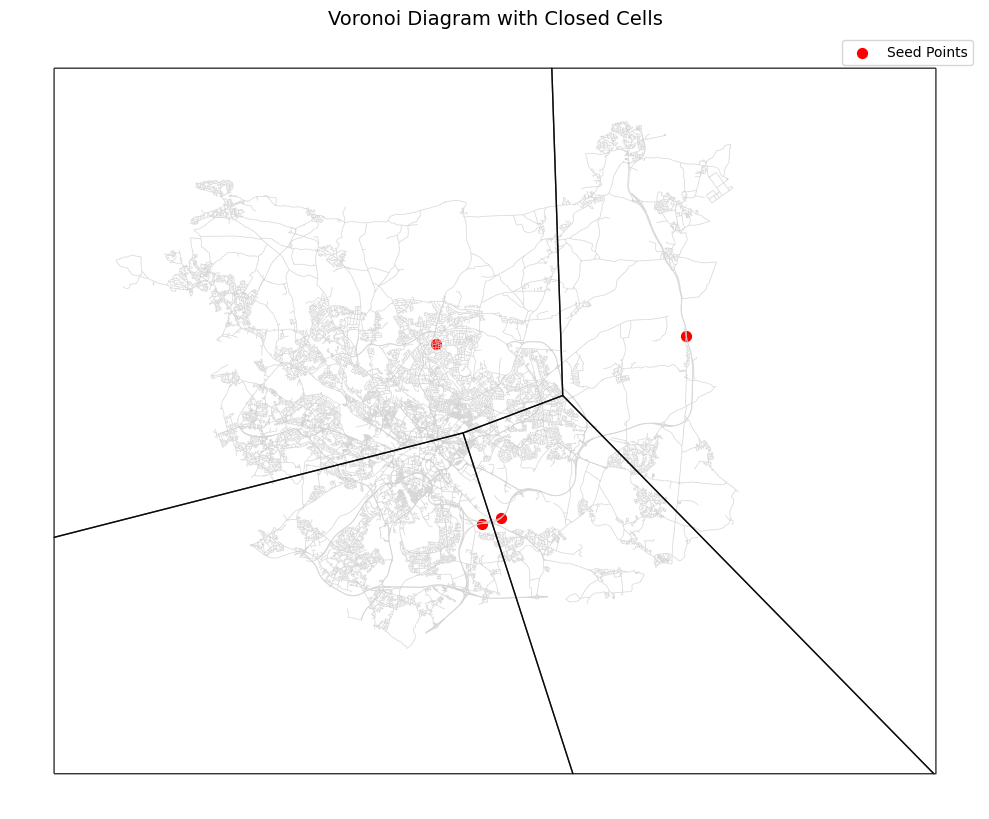

In [172]:
# Construct MultiPoint
multi_pts = MultiPoint(seed_points)

# Create an envelope Polygon using the expanded bounding box
minx, miny, maxx, maxy = accident_counts.total_bounds
dx = (maxx - minx) * 0.1  # Expand left and right by 10%
dy = (maxy - miny) * 0.1  # Expand up and down 10%
bounding_polygon = box(minx - dx, miny - dy, maxx + dx, maxy + dy)

# Construct Voronoi diagram (closed)
voronoi_result = voronoi_diagram(multi_pts, envelope=bounding_polygon, tolerance=1e-8)

# Convert to GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(geometry=[geom for geom in voronoi_result.geoms], crs=accident_counts.crs)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.5)
voronoi_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1, alpha=0.8)
seed_gdf.plot(ax=ax, color="red", markersize=50, label="Seed Points")

plt.title("Voronoi Diagram with Closed Cells", fontsize=14)
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

In [175]:
def spaghetti_to_nx(ntw):
    G = nx.Graph()
    for arc_id, arc in enumerate(ntw.arcs):
        v1, v2 = arc
        p1 = Point(ntw.vertex_coords[v1])
        p2 = Point(ntw.vertex_coords[v2])
        length = p1.distance(p2)
        G.add_edge(v1, v2, weight=length, arc_id=arc_id)
    return G

In [179]:
def find_loop_path_within_cell(ntw, G, voronoi_cell, start_node=None, target_length=42000, tolerance=2000, max_attempts=500):
    node_coords = {vid: Point(xy) for vid, xy in ntw.vertex_coords.items()}
    nodes_in_cell = [vid for vid, pt in node_coords.items() if pt.within(voronoi_cell)]

    if not nodes_in_cell:
        return None, 0

    for _ in range(max_attempts):
        s = start_node if start_node else random.choice(nodes_in_cell)
        t = random.choice(nodes_in_cell)
        if s == t:
            continue

        try:
            path = nx.shortest_path(G, source=s, target=t, weight="weight")
            loop_path = path + path[::-1][1:]  # Return to the starting point to form a closed loop
            length = sum(G[u][v]['weight'] for u, v in zip(loop_path[:-1], loop_path[1:]))
            if abs(length - target_length) <= tolerance:
                return loop_path, length
        except:
            continue

    return None, 0

In [181]:
import random

# Convert a Spaghetti network to a NetworkX graph
G_nx = spaghetti_to_nx(ntw)

# Find out whether a closed path of about 42 km can be found in each Voronoi cell
cell_paths = []

for i, cell in enumerate(voronoi_gdf.geometry):
    path, length = find_loop_path_within_cell(ntw, G_nx, cell, target_length=42000, tolerance=2000)
    if path:
        print(f"Cell {i}: Found loop ~{length:.1f} meters")
        cell_paths.append((i, path, length))
    else:
        print(f"Cell {i}: No valid path found")

Cell 0: Found loop ~42623.2 meters
Cell 1: Found loop ~41190.3 meters
Cell 2: No valid path found
Cell 3: No valid path found


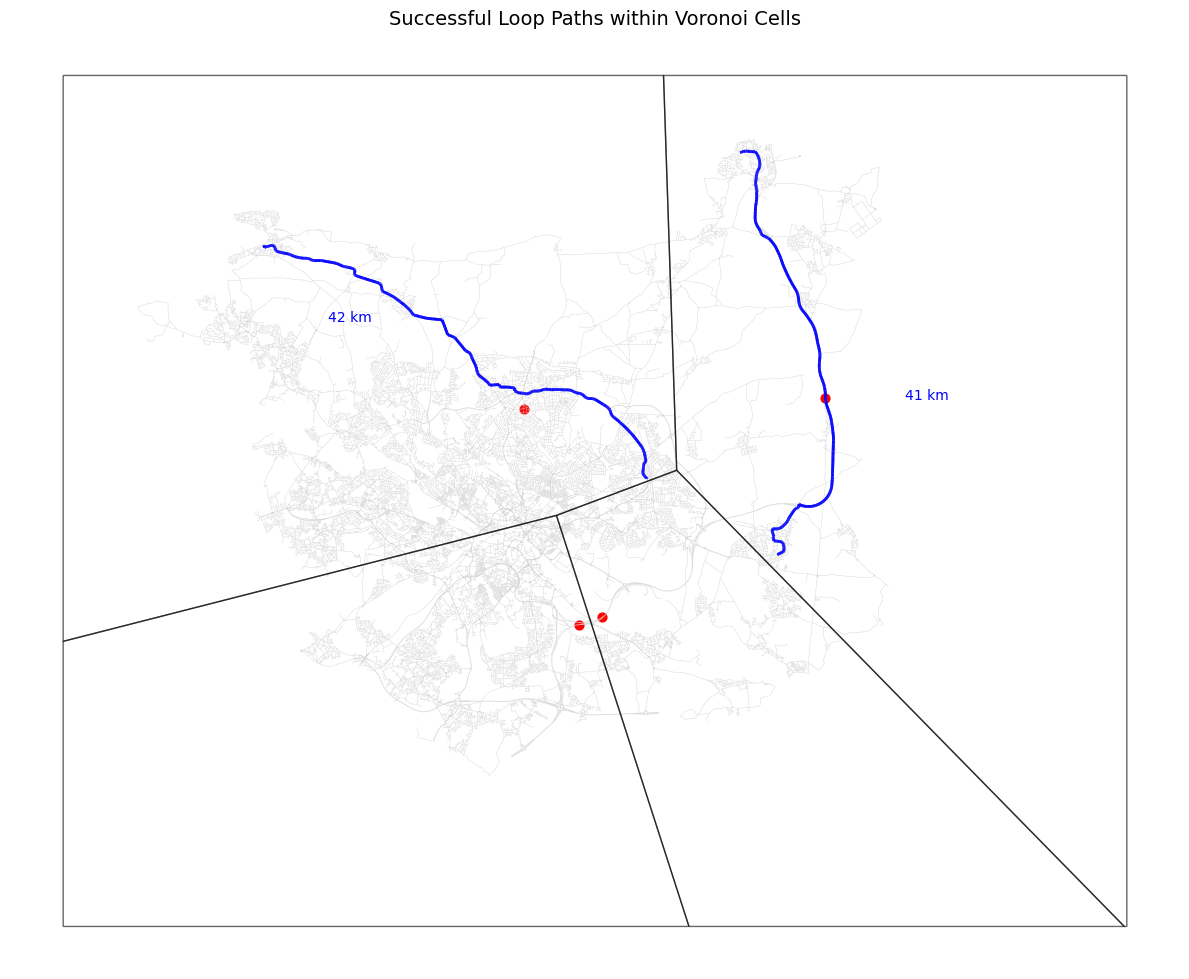

In [186]:
# Visualize successful paths and pathfinding attempts to expand failed cells
# Visualize the Voronoi Cells and Paths of the Found Path
fig, ax = plt.subplots(figsize=(12, 12))
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.3)
voronoi_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1, alpha=0.6)
seed_gdf.plot(ax=ax, color="red", markersize=40, label="Seed Points")

# Charting a path to success
for cell_id, path, length in cell_paths:
    lines = []
    for u, v in zip(path[:-1], path[1:]):
        p1 = Point(ntw.vertex_coords[u])
        p2 = Point(ntw.vertex_coords[v])
        lines.append(LineString([p1, p2]))
    path_line = gpd.GeoSeries(lines, crs=accident_counts.crs)
    path_line.plot(ax=ax, linewidth=2, color="blue", alpha=0.8)

    # Mark length at center
    centroid = voronoi_gdf.iloc[cell_id].geometry.centroid
    ax.text(centroid.x, centroid.y, f"{int(length/1000)} km", fontsize=10, color="blue", ha="center")

plt.title("Successful Loop Paths within Voronoi Cells", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [188]:
# Try again to find a path in the failed cell (increasing the number of attempts and the tolerance)
remaining_cells = set(range(len(voronoi_gdf))) - {i for i, _, _ in cell_paths}

for i in remaining_cells:
    cell = voronoi_gdf.iloc[i].geometry
    path, length = find_loop_path_within_cell(
        ntw, G_nx, cell, target_length=42000, tolerance=3000, max_attempts=1000
    )
    if path:
        print(f"Retry Cell {i}: Found loop ~{length:.1f} meters")
        cell_paths.append((i, path, length))
    else:
        print(f"Retry Cell {i}: Still no valid path")

Retry Cell 2: Still no valid path
Retry Cell 3: Still no valid path


In [192]:
# Clustering with KMeans for N=6 seed points
N = 6
edge_centers = accident_counts.geometry.interpolate(0.5, normalized=True)
coords = np.array([[pt.x, pt.y] for pt in edge_centers])

kmeans = KMeans(n_clusters=N, random_state=42).fit(coords)
cluster_centers = kmeans.cluster_centers_

# In each cluster, select the edge center point with the least accidents as the seed
seed_points = []
for label in range(N):
    indices_in_cluster = np.where(kmeans.labels_ == label)[0]
    best_idx = None
    min_acc = float("inf")
    
    for idx in indices_in_cluster:
        acc = accident_counts.iloc[idx]["acc_count"]
        if acc < min_acc:
            min_acc = acc
            best_idx = idx
    
    pt = edge_centers.iloc[best_idx]
    seed_points.append(Point(pt.x, pt.y))

seed_gdf = gpd.GeoDataFrame(geometry=seed_points, crs=accident_counts.crs)

In [193]:
# Construct a Voronoi diagram (with boundary clipping)
multi_pts = MultiPoint(seed_points)
minx, miny, maxx, maxy = accident_counts.total_bounds
dx, dy = (maxx - minx) * 0.1, (maxy - miny) * 0.1
bounding_polygon = box(minx - dx, miny - dy, maxx + dx, maxy + dy)

voronoi_result = voronoi_diagram(multi_pts, envelope=bounding_polygon, tolerance=1e-8)
voronoi_gdf = gpd.GeoDataFrame(geometry=[geom for geom in voronoi_result.geoms], crs=accident_counts.crs)

In [195]:
# Converting Spaghetti networks to NetworkX
G_nx = spaghetti_to_nx(ntw)

# Re-find the closed loop paths of all cells
cell_paths = []
for i, cell in enumerate(voronoi_gdf.geometry):
    path, length = find_loop_path_within_cell(ntw, G_nx, cell, target_length=42000, tolerance=2000)
    if path:
        print(f"Cell {i}: Found loop ~{length:.1f} meters")
        cell_paths.append((i, path, length))
    else:
        print(f"Cell {i}: No valid path found")

Cell 0: No valid path found
Cell 1: No valid path found
Cell 2: No valid path found
Cell 3: No valid path found
Cell 4: Found loop ~40921.9 meters
Cell 5: No valid path found


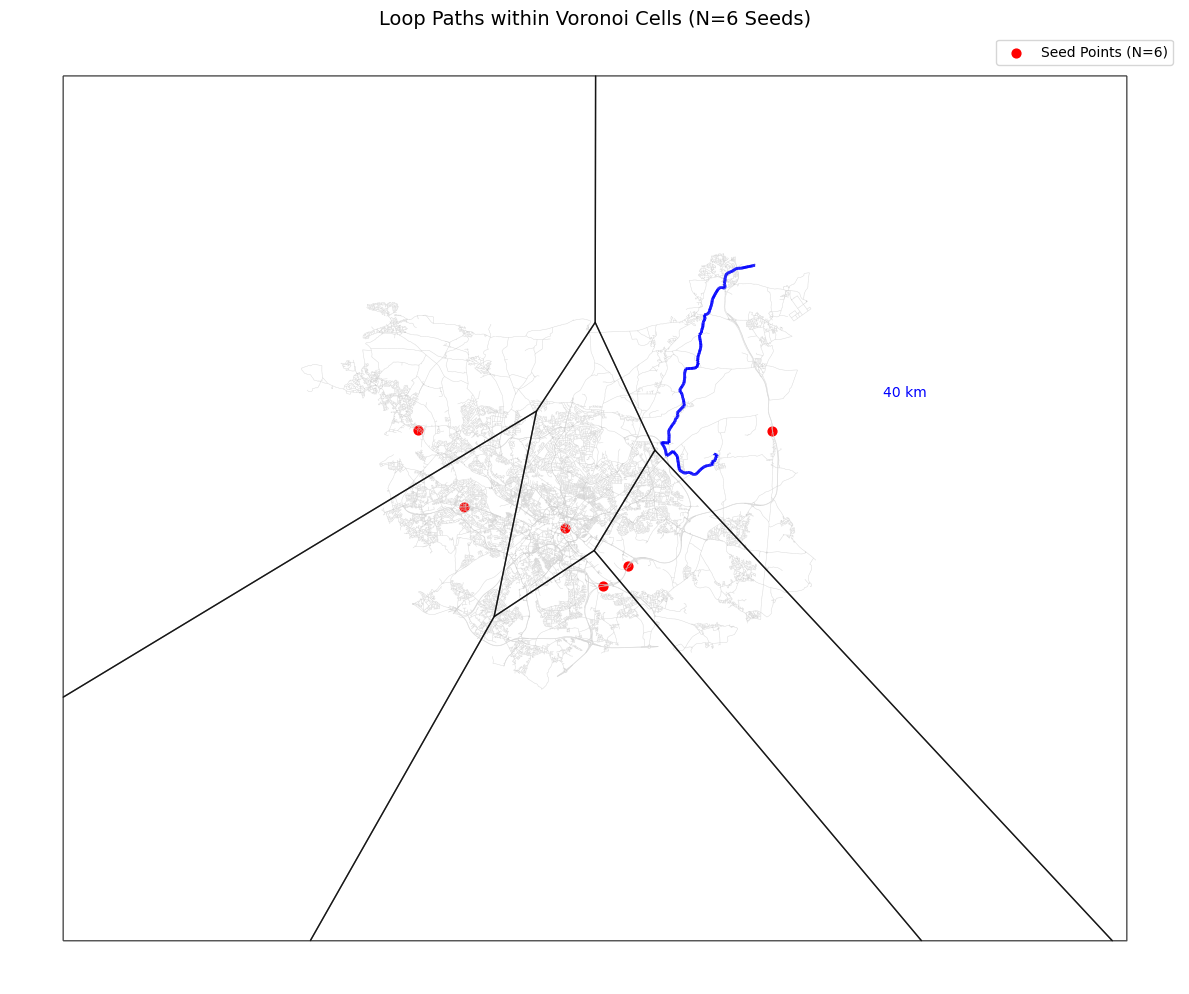

In [197]:
# Visualize N=6 seed points, Voronoi partitions, and found paths
fig, ax = plt.subplots(figsize=(12, 12))
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.3)
voronoi_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1, alpha=0.7)
seed_gdf.plot(ax=ax, color="red", markersize=40, label="Seed Points (N=6)")

# Draw a closed loop path
for cell_id, path, length in cell_paths:
    lines = []
    for u, v in zip(path[:-1], path[1:]):
        p1 = Point(ntw.vertex_coords[u])
        p2 = Point(ntw.vertex_coords[v])
        lines.append(LineString([p1, p2]))
    path_line = gpd.GeoSeries(lines, crs=accident_counts.crs)
    path_line.plot(ax=ax, linewidth=2, color="blue", alpha=0.8)

    # Marking path length
    centroid = voronoi_gdf.iloc[cell_id].geometry.centroid
    ax.text(centroid.x, centroid.y, f"{int(length/1000)} km", fontsize=10, color="blue", ha="center")

plt.title("Loop Paths within Voronoi Cells (N=6 Seeds)", fontsize=14)
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

In [203]:
# Get the coordinates of all road midpoints
edge_centers = accident_counts.geometry.interpolate(0.5, normalized=True)
coords = np.array([[pt.x, pt.y] for pt in edge_centers])

# Clustering into 8 centers using KMeans
kmeans_8 = KMeans(n_clusters=8, random_state=42).fit(coords)
labels_8 = kmeans_8.labels_

# In each cluster, the center point with the least accidents is selected as the seed point
seed_points_8 = []
for label in range(8):
    indices = np.where(labels_8 == label)[0]
    min_acc = float('inf')
    best_idx = None
    for idx in indices:
        acc = accident_counts.iloc[idx]["acc_count"]
        if acc < min_acc:
            min_acc = acc
            best_idx = idx
    pt = edge_centers.iloc[best_idx]
    seed_points_8.append(Point(pt.x, pt.y))

# Construct a GeoDataFrame of seed points
seed_gdf_8 = gpd.GeoDataFrame(geometry=seed_points_8, crs=accident_counts.crs)

# Construct a Voronoi diagram (using a closed enveloping polygon)
multi_pts_8 = MultiPoint(seed_points_8)
minx, miny, maxx, maxy = accident_counts.total_bounds
dx = (maxx - minx) * 0.1
dy = (maxy - miny) * 0.1
bounding_polygon_8 = box(minx - dx, miny - dy, maxx + dx, maxy + dy)

voronoi_result_8 = voronoi_diagram(multi_pts_8, envelope=bounding_polygon_8, tolerance=1e-8)
voronoi_gdf_8 = gpd.GeoDataFrame(geometry=[geom for geom in voronoi_result_8.geoms], crs=accident_counts.crs)

In [204]:
# Convert the network to a NetworkX graph
G_nx_8 = spaghetti_to_nx(ntw)

# Try to find a closed loop path in each cell
cell_paths_8 = []

for i, cell in enumerate(voronoi_gdf_8.geometry):
    path, length = find_loop_path_within_cell(
        ntw, G_nx_8, cell, target_length=42000, tolerance=2000
    )
    if path:
        print(f"Cell {i}: Found loop ~{length:.1f} meters")
        cell_paths_8.append((i, path, length))
    else:
        print(f"Cell {i}: No valid path found")

Cell 0: No valid path found
Cell 1: No valid path found
Cell 2: No valid path found
Cell 3: No valid path found
Cell 4: Found loop ~43853.5 meters
Cell 5: No valid path found
Cell 6: No valid path found
Cell 7: No valid path found


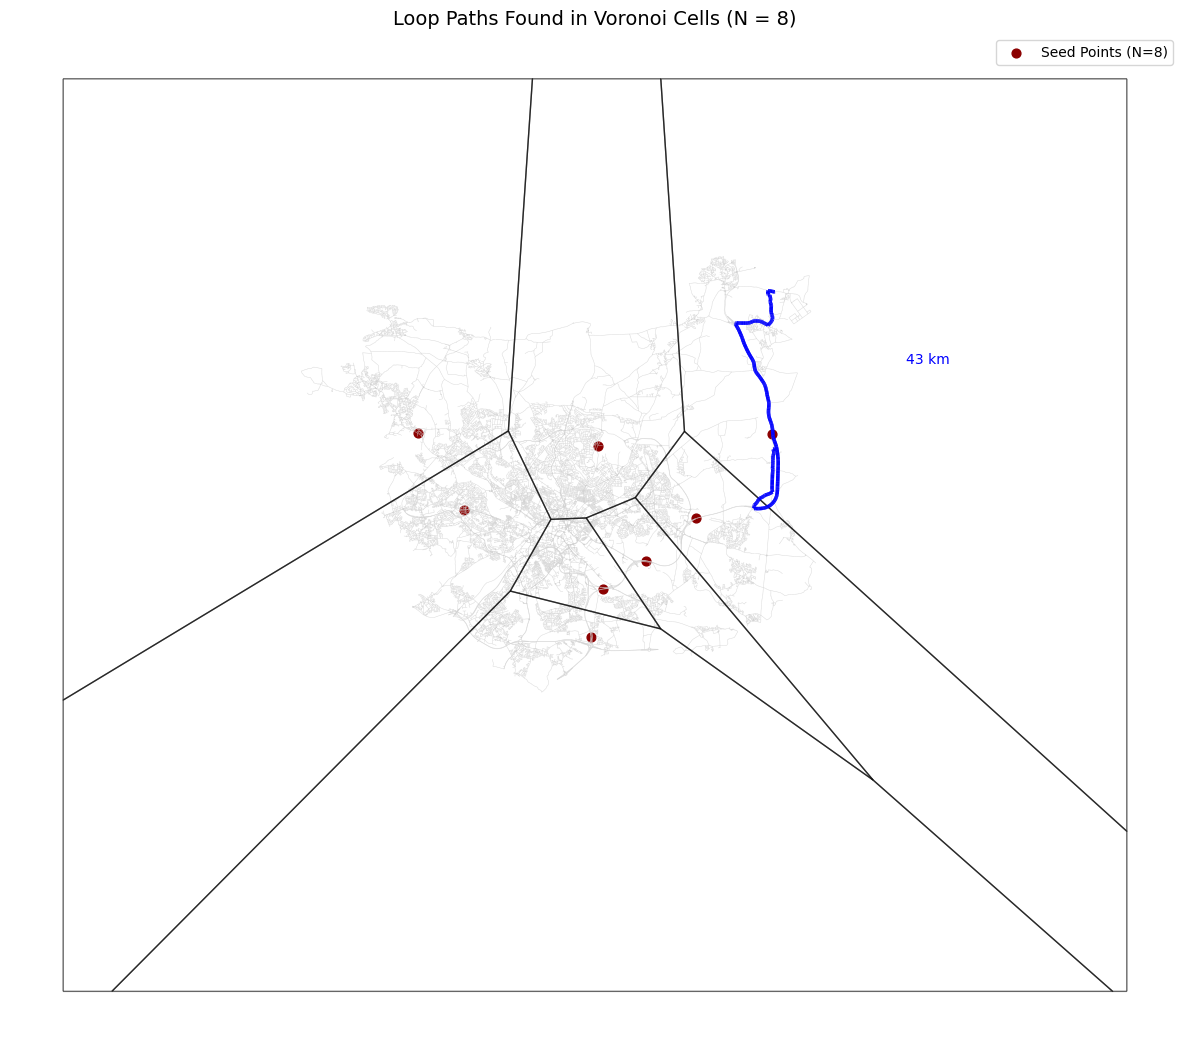

In [205]:
# Visualize the Path to Success (8-Point Strategy)
fig, ax = plt.subplots(figsize=(12, 12))

# Background: Roads & Voronoi Zoning
accident_counts.plot(ax=ax, color="lightgray", linewidth=0.3)
voronoi_gdf_8.boundary.plot(ax=ax, edgecolor="black", linewidth=1, alpha=0.6)
seed_gdf_8.plot(ax=ax, color="darkred", markersize=40, label="Seed Points (N=8)")

# Successful path superposition
for cell_id, path, length in cell_paths_8:
    lines = []
    for u, v in zip(path[:-1], path[1:]):
        p1 = Point(ntw.vertex_coords[u])
        p2 = Point(ntw.vertex_coords[v])
        lines.append(LineString([p1, p2]))
    path_line = gpd.GeoSeries(lines, crs=accident_counts.crs)
    path_line.plot(ax=ax, linewidth=2.5, color="blue", alpha=0.85)

    # Marking path length
    centroid = voronoi_gdf_8.iloc[cell_id].geometry.centroid
    ax.text(centroid.x, centroid.y, f"{int(length/1000)} km", fontsize=10, color="blue", ha="center")

plt.title("Loop Paths Found in Voronoi Cells (N = 8)", fontsize=14)
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

### Task D: TransE, PROV, PageRank

In [220]:
# Build a Marathon event traceability graph that conforms to the W3C PROV model (at least 20 nodes, 1 connected graph)
# Initialize the directed graph
G = nx.DiGraph()

# Define Agent (organizer, city department, etc.)
agents = {
    "Mayor": "prov:Agent",
    "TransportDept": "prov:Agent",
    "HealthDept": "prov:Agent",
    "EventOrgA": "prov:Agent",
    "EventOrgB": "prov:Agent",
    "Police": "prov:Agent",
    "VolunteerTeam": "prov:Agent"
}

# Add Agent Node
for node, t in agents.items():
    G.add_node(node, type=t)

In [221]:
# Defining Activities
activities = {
    "PlanMarathon": "prov:Activity",
    "ApproveRoutes": "prov:Activity",
    "MedicalSetup": "prov:Activity",
    "TrafficControl": "prov:Activity",
    "EventPromotion": "prov:Activity",
    "RunMarathon": "prov:Activity",
    "PostReport": "prov:Activity"
}

# Add Activity Node
for node, t in activities.items():
    G.add_node(node, type=t)

# Define Entities
entities = {
    "MarathonPlan.pdf": "prov:Entity",
    "ApprovedRoute.geojson": "prov:Entity",
    "MedicalKitList.xlsx": "prov:Entity",
    "PromoPoster.jpg": "prov:Entity",
    "TrafficNotice.docx": "prov:Entity",
    "LiveRunData.csv": "prov:Entity",
    "FinalReport.pdf": "prov:Entity",
    "VolunteerRoster.csv": "prov:Entity"
}

# Adding an Entity Node
for node, t in entities.items():
    G.add_node(node, type=t)

In [222]:
# Define edge relationships (using W3C PROV type)
relations = [
    # Agent participates in Activity (wasAssociatedWith)
    ("Mayor", "PlanMarathon", "prov:wasAssociatedWith"),
    ("TransportDept", "ApproveRoutes", "prov:wasAssociatedWith"),
    ("HealthDept", "MedicalSetup", "prov:wasAssociatedWith"),
    ("EventOrgA", "EventPromotion", "prov:wasAssociatedWith"),
    ("Police", "TrafficControl", "prov:wasAssociatedWith"),
    ("VolunteerTeam", "RunMarathon", "prov:wasAssociatedWith"),
    ("EventOrgB", "PostReport", "prov:wasAssociatedWith"),

    # Activity uses Entity(used)
    ("ApproveRoutes", "MarathonPlan.pdf", "prov:used"),
    ("MedicalSetup", "MedicalKitList.xlsx", "prov:used"),
    ("TrafficControl", "ApprovedRoute.geojson", "prov:used"),
    ("EventPromotion", "PromoPoster.jpg", "prov:used"),
    ("RunMarathon", "VolunteerRoster.csv", "prov:used"),

    # Activity generates Entity(wasGeneratedBy)
    ("PlanMarathon", "MarathonPlan.pdf", "prov:wasGeneratedBy"),
    ("ApproveRoutes", "ApprovedRoute.geojson", "prov:wasGeneratedBy"),
    ("TrafficControl", "TrafficNotice.docx", "prov:wasGeneratedBy"),
    ("RunMarathon", "LiveRunData.csv", "prov:wasGeneratedBy"),
    ("PostReport", "FinalReport.pdf", "prov:wasGeneratedBy")
]

# Add Edge
for src, tgt, label in relations:
    G.add_edge(src, tgt, label=label)

/var/folders/dl/kdk6kjfj2p5fbtpmhk4629440000gn/T/ipykernel_47305/2161678550.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


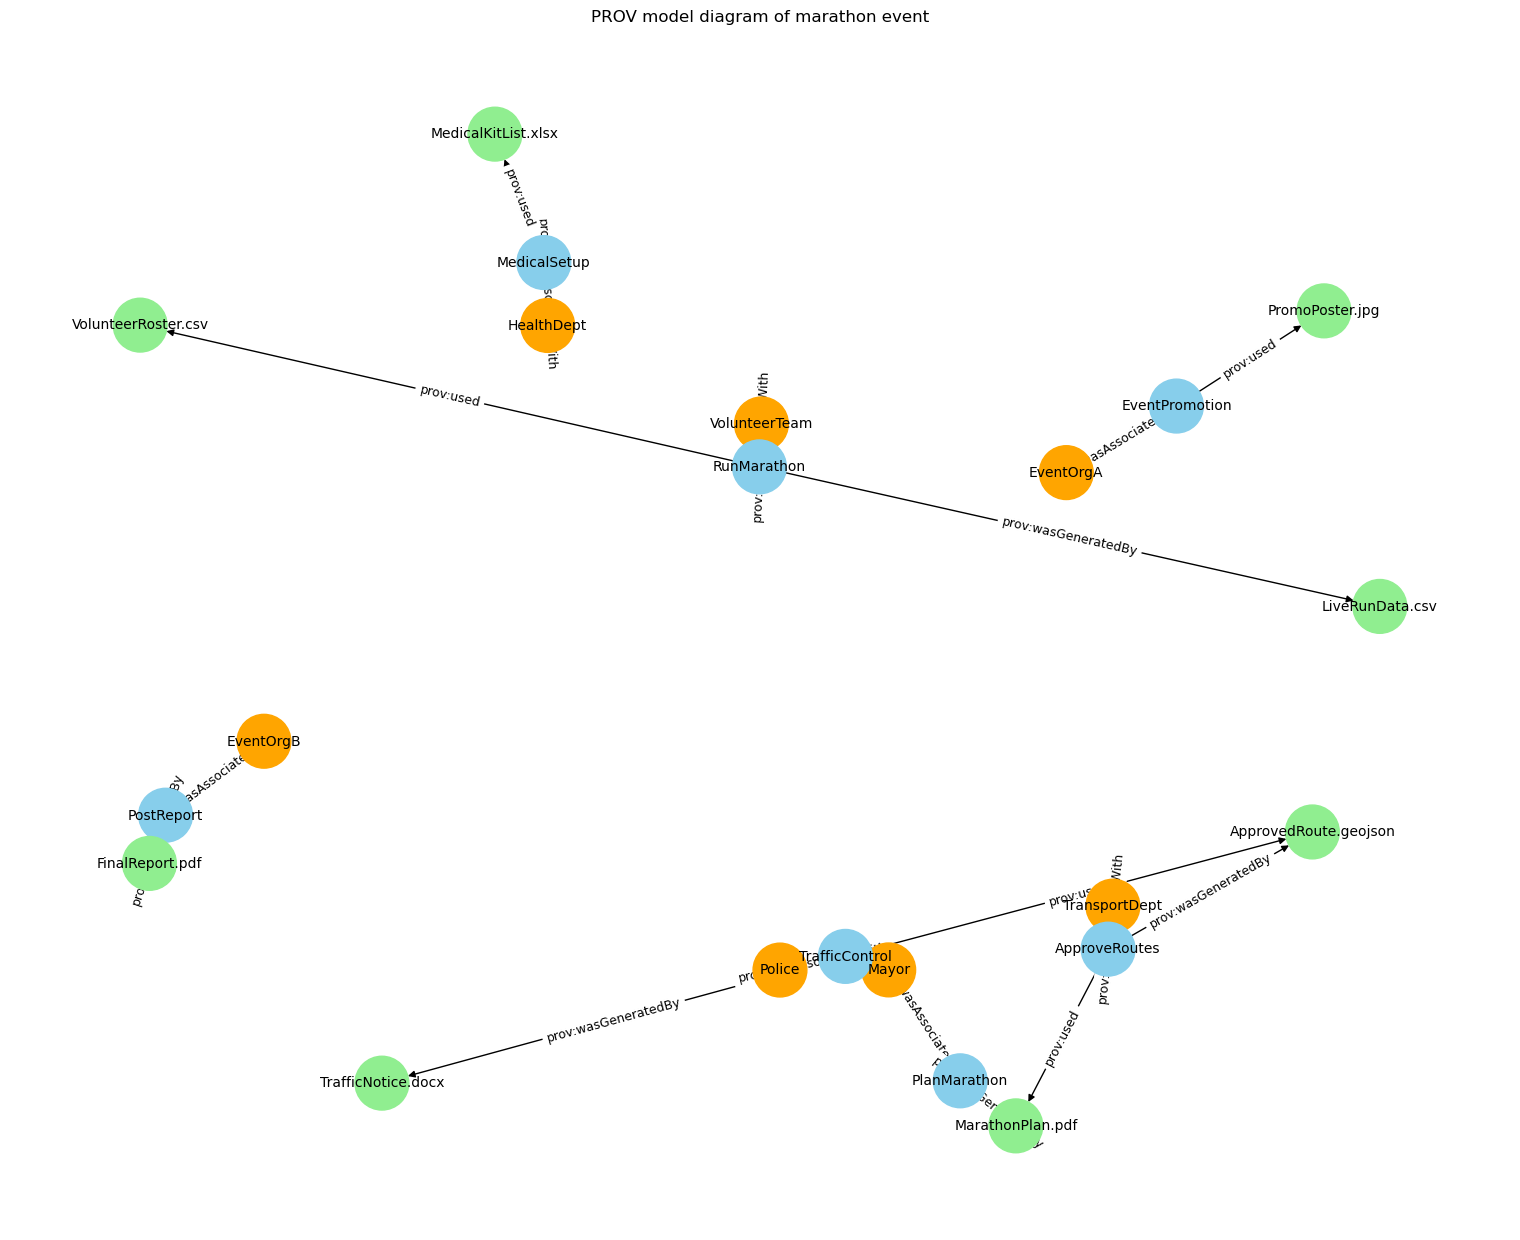

In [223]:
# Visualization
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(15, 12))

# Color by type
color_map = []
for node in G.nodes(data=True):
    if node[1]["type"] == "prov:Agent":
        color_map.append("orange")
    elif node[1]["type"] == "prov:Activity":
        color_map.append("skyblue")
    else:
        color_map.append("lightgreen")

nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1500, font_size=10)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("PROV model diagram of marathon event")
plt.axis("off")
plt.tight_layout()
plt.show()

PageRank Top 5 nodes (representing the most ‘important’ elements in the network):
MarathonPlan.pdf: 0.0862
ApprovedRoute.geojson: 0.0660
MedicalKitList.xlsx: 0.0660
PromoPoster.jpg: 0.0660
FinalReport.pdf: 0.0660


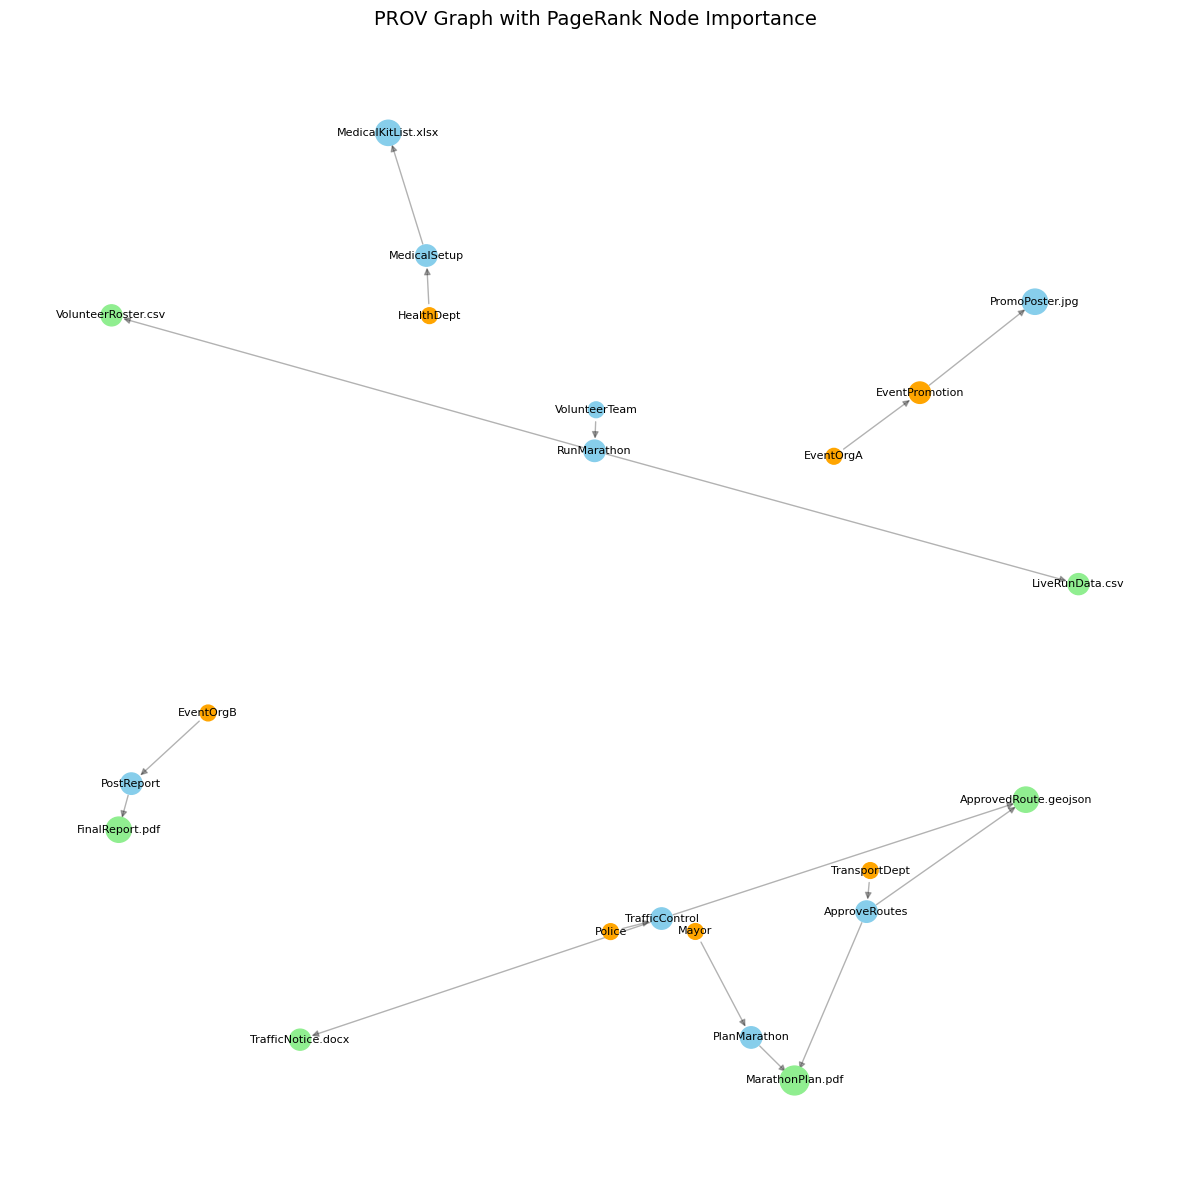

In [224]:
# Calculating PageRank scores
pagerank_scores = nx.pagerank(G, alpha=0.85)

# Print the first few nodes with the highest PageRank values
print("PageRank Top 5 nodes (representing the most ‘important’ elements in the network):")
top_nodes = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:5]
for node, score in top_nodes:
    print(f"{node}: {score:.4f}")

# Visualization: Node size adjusted according to PageRank value
plt.figure(figsize=(12, 12))

# Set the color of different types of nodes
color_map = []
for node in G.nodes():
    if node.startswith("Event") or node in ["Mayor", "Police", "TransportDept", "HealthDept"]:
        color_map.append("orange")  # Agent
    elif node.endswith(".pdf") or node.endswith(".csv") or node.endswith(".geojson") or node.endswith(".docx"):
        color_map.append("lightgreen")  # Entity
    else:
        color_map.append("skyblue")  # Activity

# Set node size based on PageRank score (magnification effect)
node_size = [pagerank_scores[n]*5000 for n in G.nodes()]

# Plot
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=node_size)
nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("PROV Graph with PageRank Node Importance", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()